In [2]:
import numpy as np
import matplotlib.pyplot as plt
frequency = 200
samplePeriod = 5

### Read Data from Serial and Store in File

In [21]:
import serial
#Ask the user to type the filename
fName = raw_input('File to store data: ') + '.txt'
#Setup the file object to write data from serial to
f = open(fName, 'w')
#Write description at the beginning of the file
f.write('EMG Data\n')
f.write('No\tRaw Data\tTime(Microseconds)\n')
ser = serial.Serial('COM6', 115200)
for i in range(0,samplePeriod * frequency):
    #Write what's exactly on serial to file
    f.write(ser.readline())

#Close file object and serial
f.close()
ser.close()
print "Save success"

File to store data: emg1
Save success


### Read data from file and plot

Data file: emg1


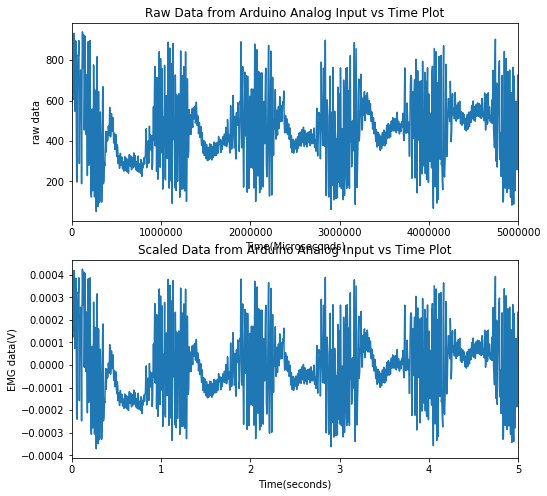

In [3]:
#Setup plot display size in jupyter notebook
%matplotlib inline
figSize = [8, 8]
plt.rcParams["figure.figsize"] = figSize

#Ask the user to type the filenames
dataFile = raw_input('Data file: ') + '.txt'
#Setup the files to read from
fData = open(dataFile, 'r')
#Create numpy array to store time
dataArray = np.empty(frequency * samplePeriod)
timeArray = np.empty_like(dataArray)
#Get rid of the first two lines in data file
fData.readline()
fData.readline()
for i in range(0,frequency * samplePeriod):
    numbers = fData.readline().split()
    dataArray[i] = numbers[1]
    timeArray[i] = numbers[2]
fData.close()
scaledDataArray = ((dataArray / 1023) * 3.3 - 1.5) / 3600 #Scale raw data
scaledTimeArray = timeArray / 10**6              #Scale time array
#Plot
plt.figure(1);
ax1 = plt.subplot(211)
ax1.plot(timeArray, dataArray);
plt.xlabel('Time(Microseconds)');
plt.ylabel('raw data');
plt.xlim(0, samplePeriod * 10**6)
plt.title('Raw Data from Arduino Analog Input vs Time Plot');

ax2 = plt.subplot(212)
plt.plot(scaledTimeArray, scaledDataArray);
plt.xlabel('Time(seconds)');
plt.ylabel('EMG data(V)');
plt.xlim(0, samplePeriod)
plt.title('Scaled Data from Arduino Analog Input vs Time Plot');


#plt.tight_layout()
plt.show()

[ 0.72944072 -2.18832217  2.18832217 -0.72944072]
[ 1.         -2.37409474  1.92935567 -0.53207537]
[ 0.16666667  0.5         0.5         0.16666667]
[  1.00000000e+00  -2.77555756e-16   3.33333333e-01  -1.85037171e-17]


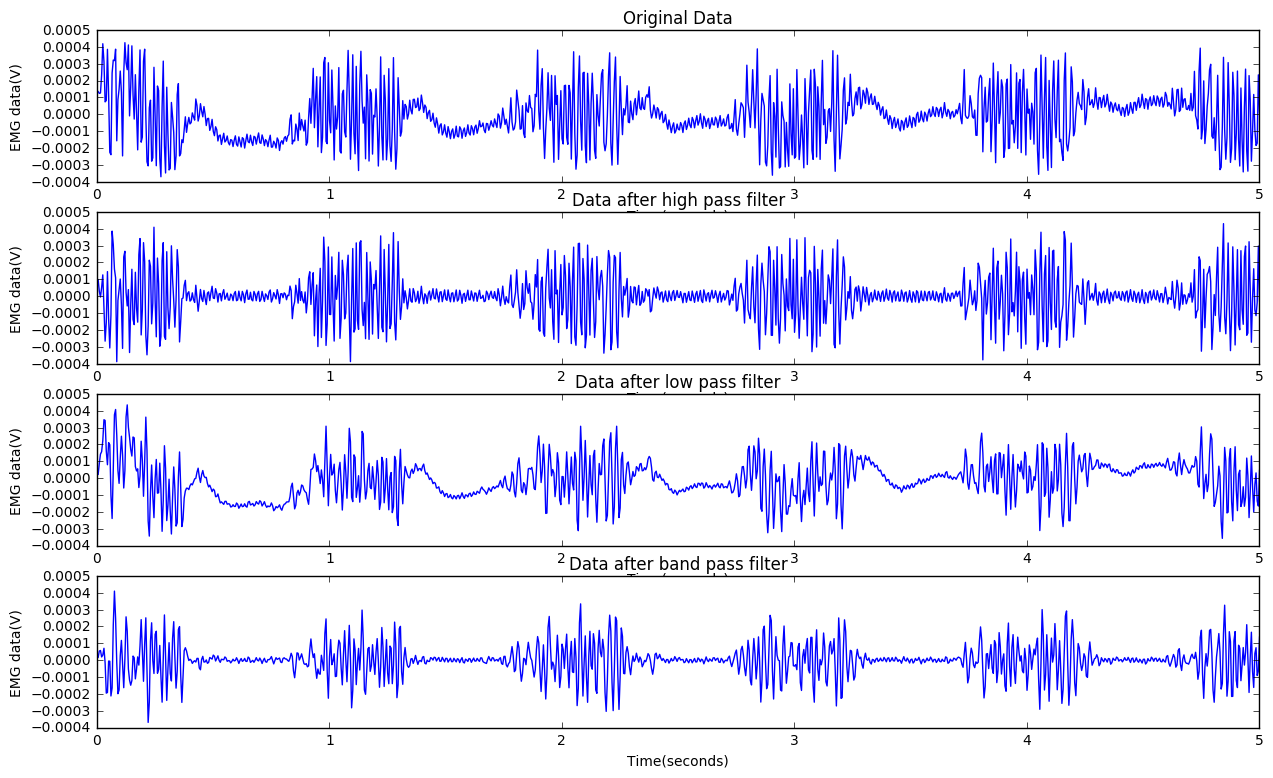

In [27]:
%matplotlib inline
figSize = [15, 9]
plt.rcParams["figure.figsize"] = figSize


from scipy import signal
#Calculate coefficiences for the high and low pass signals 
b_high, a_high = signal.butter(3, 0.1, 'high', analog=False)
b_low, a_low = signal.butter(3, .5, 'low', analog=False)
#Input scaled data into high pass filter
high_pass_data = signal.lfilter(b_high, a_high, scaledDataArray)
#Input scaled data into low pass filter
low_pass_data = signal.lfilter(b_low, a_low, scaledDataArray)
#Input high pass data into low pass filter to get band pass data
band_pass_data = signal.lfilter(b_low, a_low, high_pass_data)
#Print those coefficiences for later use
print b_high
print a_high
print b_low
print a_low
#Plot function to plot data
def plotEMG(data, time, xlabel, ylabel, title):
    plt.plot(time, data);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.xlim(0, samplePeriod)
    plt.title(title);
    
plt.figure(2)
plt.subplot(411)
plotEMG(scaledDataArray, scaledTimeArray, 'Time(seconds)', 'EMG data(V)', 'Original Data')
plt.subplot(412)
plotEMG(high_pass_data, scaledTimeArray, 'Time(seconds)', 'EMG data(V)', 'Data after high pass filter')
plt.subplot(413)
plotEMG(low_pass_data, scaledTimeArray, 'Time(seconds)', 'EMG data(V)', 'Data after low pass filter')
plt.subplot(414)
plotEMG(band_pass_data, scaledTimeArray, 'Time(seconds)', 'EMG data(V)', 'Data after band pass filter')
plt.show()

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


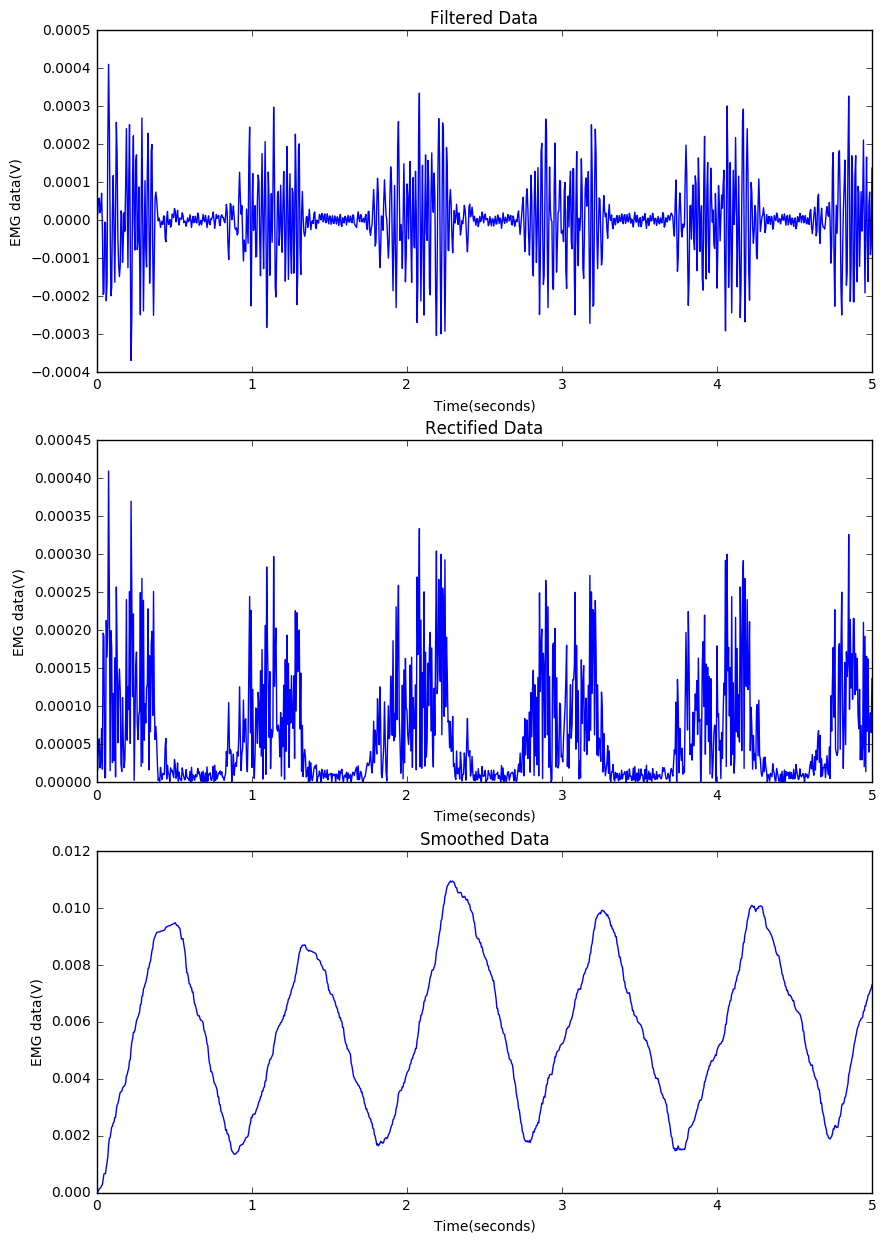

In [28]:
%matplotlib inline
figSize = [10, 15]
plt.rcParams["figure.figsize"] = figSize

#Take the absolute value of the band pass data for rectification
rectified_data = np.absolute(band_pass_data)
#Generate array for boxcar filter
box = signal.boxcar(100)
print box
#Use the boxcar filter
smoothed_data = signal.lfilter(box, 1, rectified_data)

#Plot the outputs of those filters as subplots
plt.figure(3)
plt.subplot(311)
plotEMG(band_pass_data, scaledTimeArray, 'Time(seconds)', 'EMG data(V)', 'Filtered Data')
plt.subplot(312)
plotEMG(rectified_data, scaledTimeArray, 'Time(seconds)', 'EMG data(V)', 'Rectified Data')
plt.subplot(313)
plotEMG(smoothed_data, scaledTimeArray, 'Time(seconds)', 'EMG data(V)', 'Smoothed Data')
plt.show()

# Objective 3

In [42]:
import serial
#Ask the user to type the filename
fName = raw_input('File to store data: ') + '.txt'
#Setup the file object to write data from serial to
f = open(fName, 'w')
f.write('EMG Data\n')
f.write('Time|Raw Data|Scaled Data|High Pass Data|Band Pass Data|Rectified Data|Boxcar Output|Time Spent Calculating\n')
ser = serial.Serial('COM6', 250000)
#Create numpy array to store time
for i in range(0,samplePeriod * frequency):
    f.write(ser.readline())
    
f.close()
ser.close()
print "Save success"

File to store data: emg3
Save success


In [49]:
#Ask the user to type the filenames
dataFile = raw_input('Data file: ') + '.txt'
#Setup the files to read from
fData = open(dataFile, 'r')
#Create numpy arrays to store the data
#after different real time filters from Arduino
timeArray = np.empty(frequency * samplePeriod)
rawArray = np.empty_like(dataArray)
scaledArray = np.empty_like(dataArray)
highPassArray = np.empty_like(dataArray)
bandPassArray = np.empty_like(dataArray)
rectifiedArray = np.empty_like(dataArray)
boxArray = np.empty_like(dataArray)
#Get rid of the first two lines in data file
fData.readline()
fData.readline()
#Read data from file and store into corresponding arrays
for i in range(0,frequency * samplePeriod):
    numbers = fData.readline().split()
    timeArray[i] = numbers[0]
    rawArray[i] = numbers[1]
    scaledArray[i] = numbers[2]
    highPassArray[i] = numbers[3]
    bandPassArray[i] = numbers[4]
    rectifiedArray[i] = numbers[5]
    boxArray[i] = numbers[6]
#Close file object
fData.close()

Data file: emg3


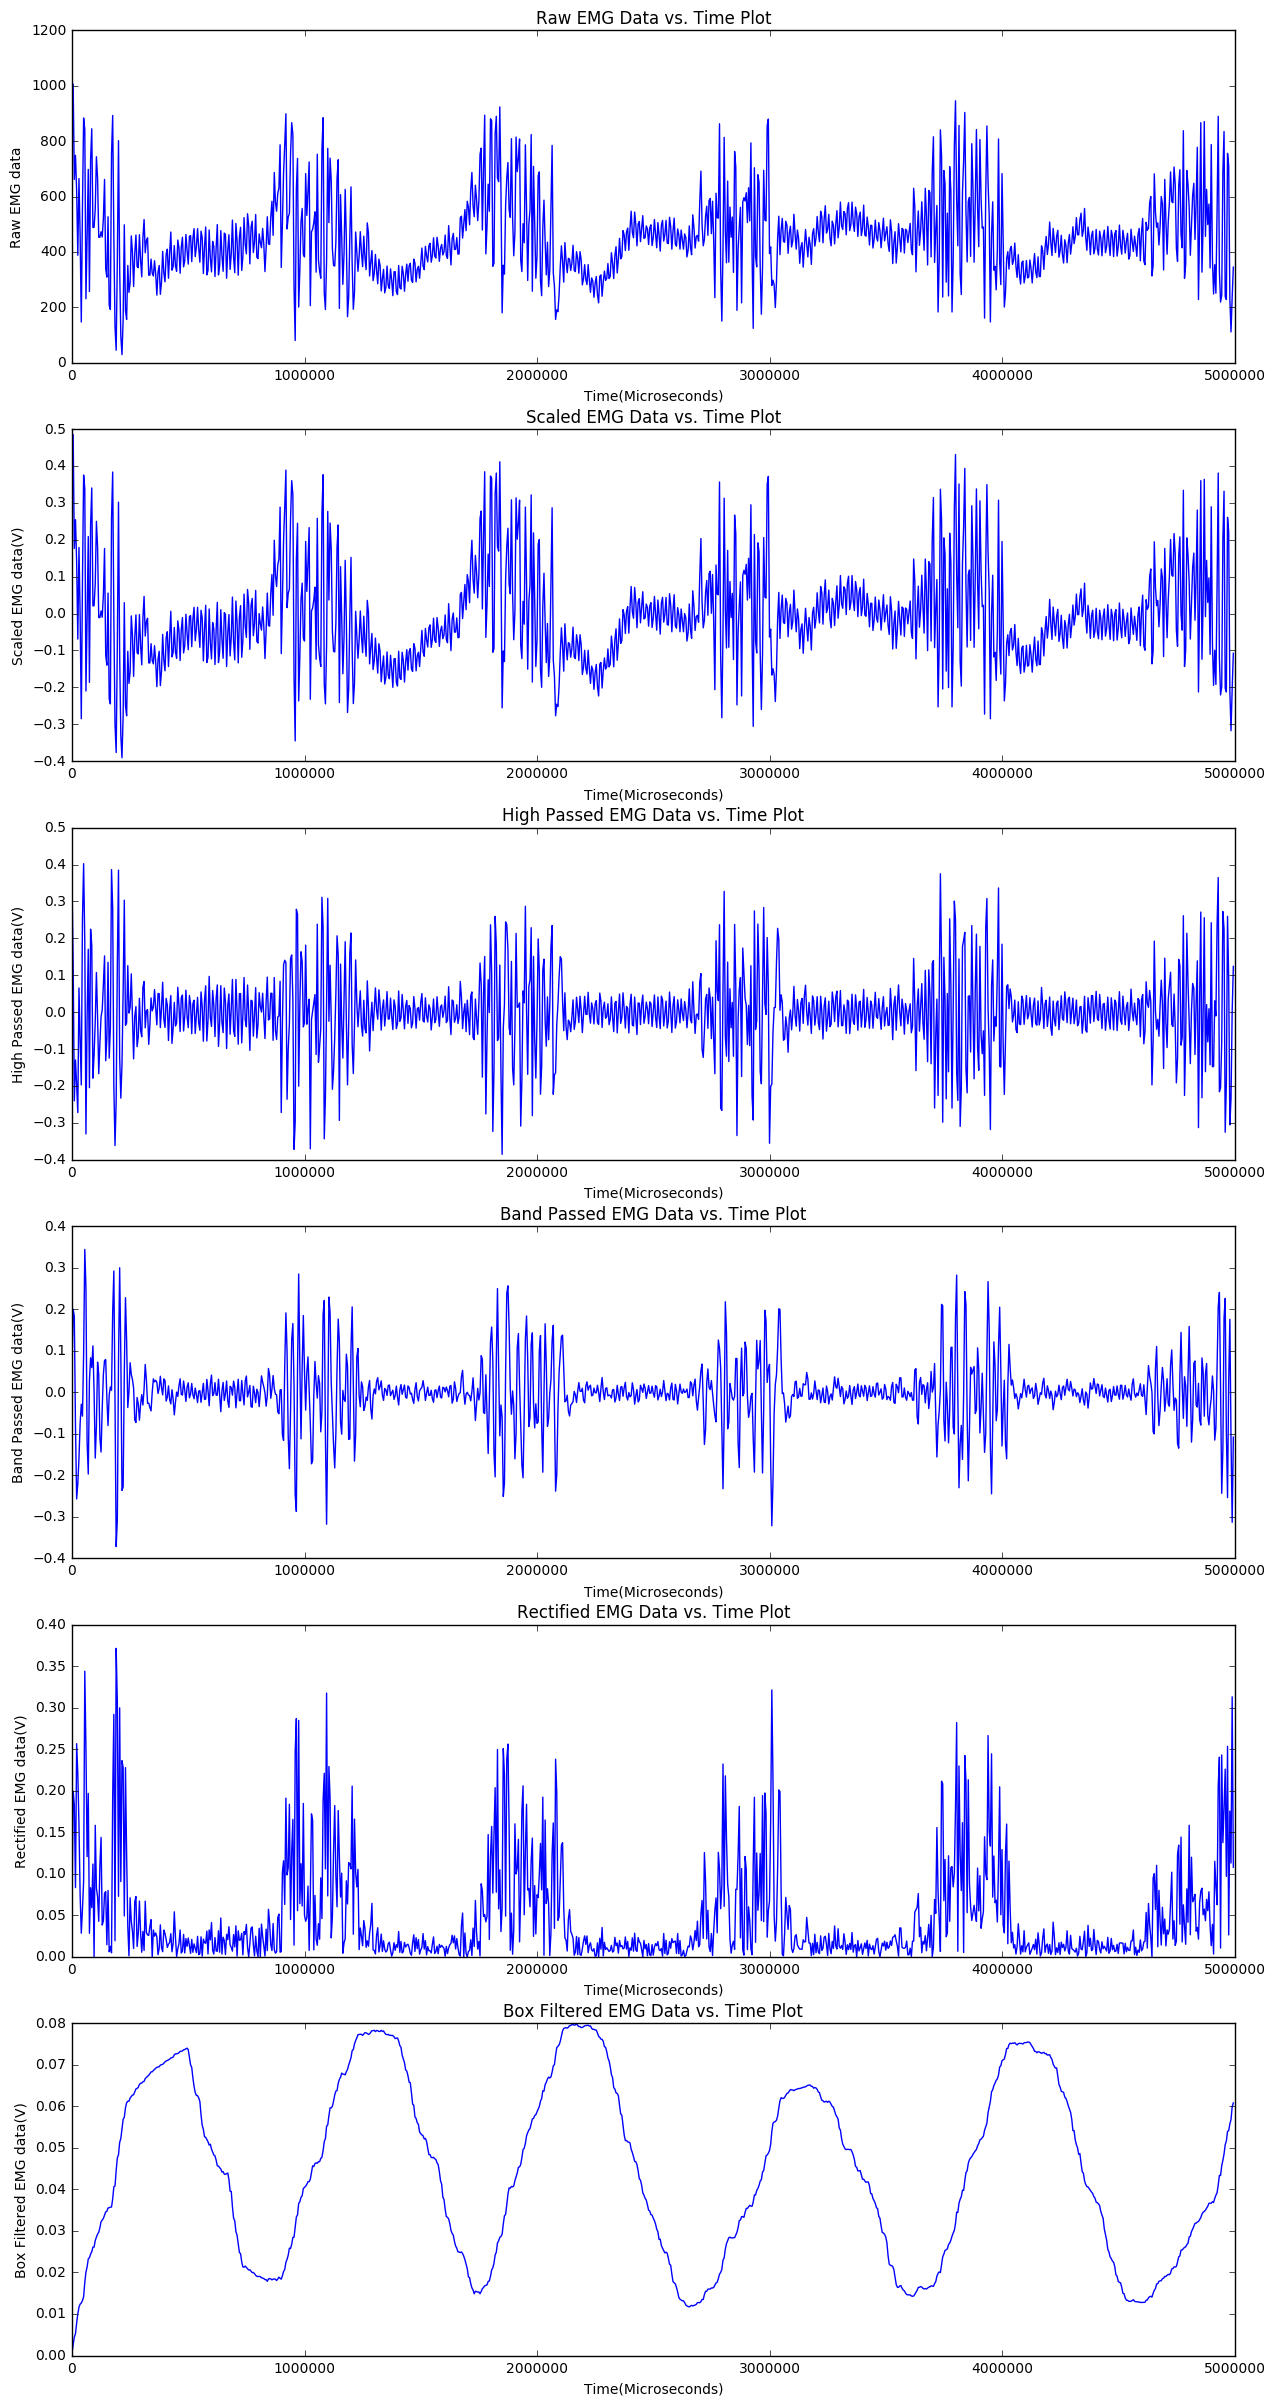

In [50]:
%matplotlib inline
figSize = [15, 30]
plt.rcParams["figure.figsize"] = figSize


#Substract every time number by the initial time
timeArray -= timeArray[0]

def plotEMGMicroseconds(data, time, xlabel, ylabel, title):
    plt.plot(time, data);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.xlim(0, samplePeriod * 1000000)
    plt.title(title);
    
#Plot
plt.figure(4);
plt.subplot(611)
plotEMGMicroseconds(rawArray, timeArray, 'Time(Microseconds)', 'Raw EMG data', 'Raw EMG Data vs. Time Plot')
plt.subplot(612)
plotEMGMicroseconds(scaledArray, timeArray, 'Time(Microseconds)', 'Scaled EMG data(V)', 'Scaled EMG Data vs. Time Plot')
plt.subplot(613)
plotEMGMicroseconds(highPassArray, timeArray, 'Time(Microseconds)', 'High Passed EMG data(V)', 'High Passed EMG Data vs. Time Plot')
plt.subplot(614)
plotEMGMicroseconds(bandPassArray, timeArray, 'Time(Microseconds)', 'Band Passed EMG data(V)', 'Band Passed EMG Data vs. Time Plot')
plt.subplot(615)
plotEMGMicroseconds(rectifiedArray, timeArray, 'Time(Microseconds)', 'Rectified EMG data(V)', 'Rectified EMG Data vs. Time Plot')
plt.subplot(616)
plotEMGMicroseconds(boxArray, timeArray, 'Time(Microseconds)', 'Box Filtered EMG data(V)', 'Box Filtered EMG Data vs. Time Plot')
plt.show()

# Objective 4

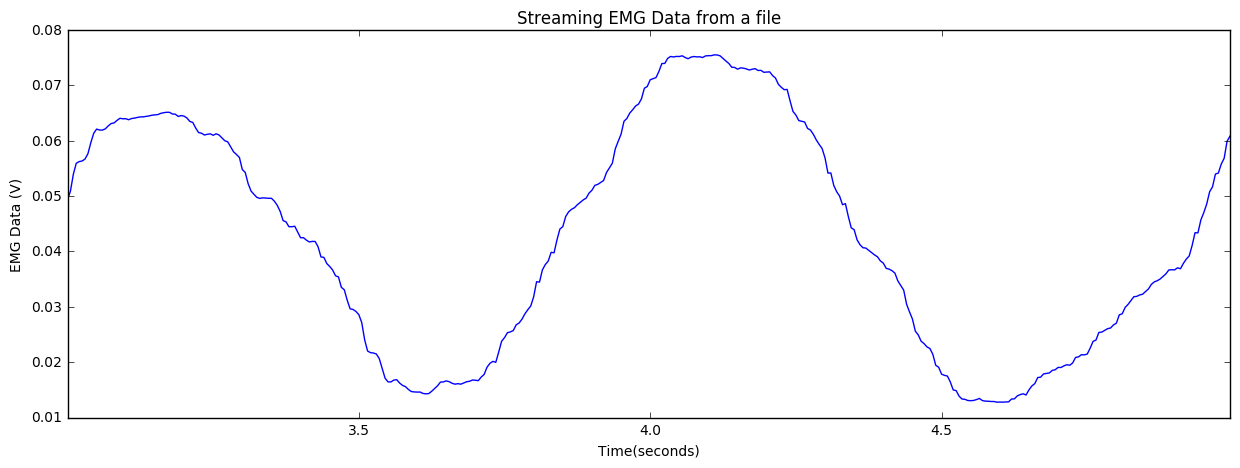

End of file


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

#Configure plot size
%matplotlib inline
figSize = [15,5]
plt.rcParams["figure.figsize"] = figSize


#Open a data file and get rid of first two lines (title)
f = open('emg3.txt', 'r')
f.readline()
f.readline()
#Declare two empty arrays to store time/EMG voltage read
timeData = np.zeros(0)
emgData = np.zeros(0)
initTime = 0
#Function to read next 20 data and update data array
def readData():
    global timeData, emgData, initTime
    timeArray = np.zeros(20)
    dataArray = np.zeros(20)
    for i in range(0,20):
        line = f.readline().split()
        timeArray[i] = line[0]
        dataArray[i] = line[6]
    timeData = np.append(timeData,timeArray)
    emgData = np.append(emgData, dataArray)
    if(initTime == 0):
        initTime = timeArray[0]
    if(len(timeData) > 400):
        timeData = np.delete(timeData, range(0,20))
        emgData = np.delete(emgData, range(0,20))
#Function to stream data until keyboard interrupt
def play():
    global timeData, emgData, initTime
    plt.ion()
    plt.hold(False)
    lineHandle = plt.plot(timeData, emgData)
    plt.plot(timeData, emgData)
    while 1:
        try:
            #Update data in two arrays
            readData()
            #Plot with time scaled into seconds
            plt.plot((timeData - initTime) / pow(10,6), emgData)
            #Update x and y data with new data arrays
            lineHandle[0].set_ydata(emgData)
            lineHandle[0].set_xdata(timeData)
            #Clear previous graph (for Jupyter only)
            display.clear_output(wait=True)
            #Setup correct x limit to display correct data
            plt.xlim((timeData[0] - initTime) / pow(10,6),(timeData[-1] - initTime) / pow(10,6))
            plt.xlabel('Time(seconds)')
            plt.ylabel('EMG Data (V)')
            plt.title('Streaming EMG Data from a file')
            plt.show()

        except KeyboardInterrupt: #When user interrupt the program, end the loop
            plt.close()
            f.close()
            return
        
try:
    play()
except IndexError: #When the file reaches an end
    print "End of file"
    plt.close()
    f.close()